# Trajectory Arrows

Draw arrows along the main trajectories. Based on `20201025_trajectory_viz/TrajViz.ipynb`

Inputs:
1. Metadata for ATAC
2. Cluster config
3. Pseudotime

In [66]:
library(ggplot2)

In [5]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

## Load Inputs

### ATAC MetaData

In [6]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 53906     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AACGCGAGAAGGACCA,AACGCGAGAAGGACCA,D0,8.373301,-4.292619,5,D0_AACGCGAGAAGGACCA
D0_AACGCGCTGTCTGTGA,AACGCGCTGTCTGTGA,D0,2.033609,-7.860645,5,D0_AACGCGCTGTCTGTGA
D0_ACCTATGGACTCGATA,ACCTATGGACTCGATA,D0,3.093788,-7.469210,5,D0_ACCTATGGACTCGATA
D0_ACGCAGAGATAACCCA,ACGCAGAGATAACCCA,D0,6.001364,-7.523576,5,D0_ACGCAGAGATAACCCA
D0_ACTCGCTACTTGTGAC,ACTCGCTACTTGTGAC,D0,3.343237,-8.114589,5,D0_ACTCGCTACTTGTGAC


### Cluster Config

In [7]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster,colour,description,new_cluster
<int>,<fct>,<fct>,<int>
1,#A6D854,Pre-iPSC,14
2,#F0A118,Intermediate,12
3,#E85F6D,Fibroblast-like,3
4,#006658,Neural-like,8
5,#B03743,Fibroblast,1
6,#CF175A,Fibroblast-like,4
7,#78A824,Pre-iPSC,13
8,#F4D5CD,Intermediate,11
9,#D4B81C,Intermediate,9


In [8]:
metaData$cluster_new_id = cluster_config[metaData$cluster, "new_cluster"]

### ATAC Pseudotime

In [10]:
pseudotime = read.table("../../analysis/20200217_trajectory/sessions/20201022_n53906/pseudotime.tsv")
rownames(pseudotime) = pseudotime$sample_barcode
pseudotime$sample_barcode = NULL
all(rownames(pseudotime) == rownames(metaData))
head(pseudotime)

[1] TRUE

,dpt_pseudotime
,<dbl>
D0_AACGCGAGAAGGACCA,0.00000000
D0_AACGCGCTGTCTGTGA,0.20646924
D0_ACCTATGGACTCGATA,0.17054172
D0_ACGCAGAGATAACCCA,0.09116346
D0_ACTCGCTACTTGTGAC,0.16613631
D0_AGACTACTGGCAGTTT,0.05593833


## Plot

In [55]:
ALL_PATHS = list(c(1,2,3,4,5), # non reprog
                c(1,6), # ker
                c(1,7,8), # neur
#                 c(1,7,9,10), # partial
                c(1,7,11,12,13,14)) #reprog


COLS = c("tomato", "purple", "blue", "black")

In [56]:
plot_dimred <- function(x, y, col, dimred="UMAP", subset=NULL, sz=0.5, alpha=1) {
    plot_df <- data.frame(x=x, y=y,
                 cluster=col)
    plot_df = plot_df[sample(dim(plot_df)[1]), ]
    
    if (!is.null(subset)) {
        plot_df = plot_df[plot_df$cluster==subset, ]
    }
    
    ggplot(plot_df) +
    geom_point(aes(x=x, y=y, color=cluster), stroke=0, size=sz, alpha=alpha) +
    theme_classic() +
    xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()
}

In [61]:
path_plot <- plot_dimred(metaData$umap1,
           metaData$umap2,
           factor(metaData$cluster_new_id),
                         alpha=0.5,
                        sz=0.25) + 
scale_color_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) +
ggtitle("Main Trajectories") +
theme(legend.position="none",  plot.title=element_text(size=18)) 

for (i in seq(length(ALL_PATHS))) {
    selected = which(metaData$cluster_new_id %in% ALL_PATHS[[i]])
    path.df <- data.frame(x = smooth.spline(metaData$umap1[selected][order(pseudotime[selected,"dpt_pseudotime"])], df=200, spar=.9)$y, 
                        y = smooth.spline(metaData$umap2[selected][order(pseudotime[selected,"dpt_pseudotime"])], df=200, spar=.9)$y)
    
    path_plot = path_plot + 
        geom_path(data=path.df, 
                  aes(x, y), 
                  size=1.5,
                  alpha=.8,
                  color=COLS[i], 
                  arrow=arrow(type="closed",
                              length=unit(.02, "npc")))
} 

In [62]:
# add annotations
TXTSZ = 5

path_plot = path_plot + 
            annotate("text", size=TXTSZ, x=7,y=7, label="Reprogramming") +
            annotate("text", size=TXTSZ, x=3,y=2, label="Fibroblast-like") +
            annotate("text", size=TXTSZ, x= -7,y= -6.5, label="Keratinocyte-like") +
            annotate("text", size=TXTSZ, x= -13, y=-2, label="High OSKM")

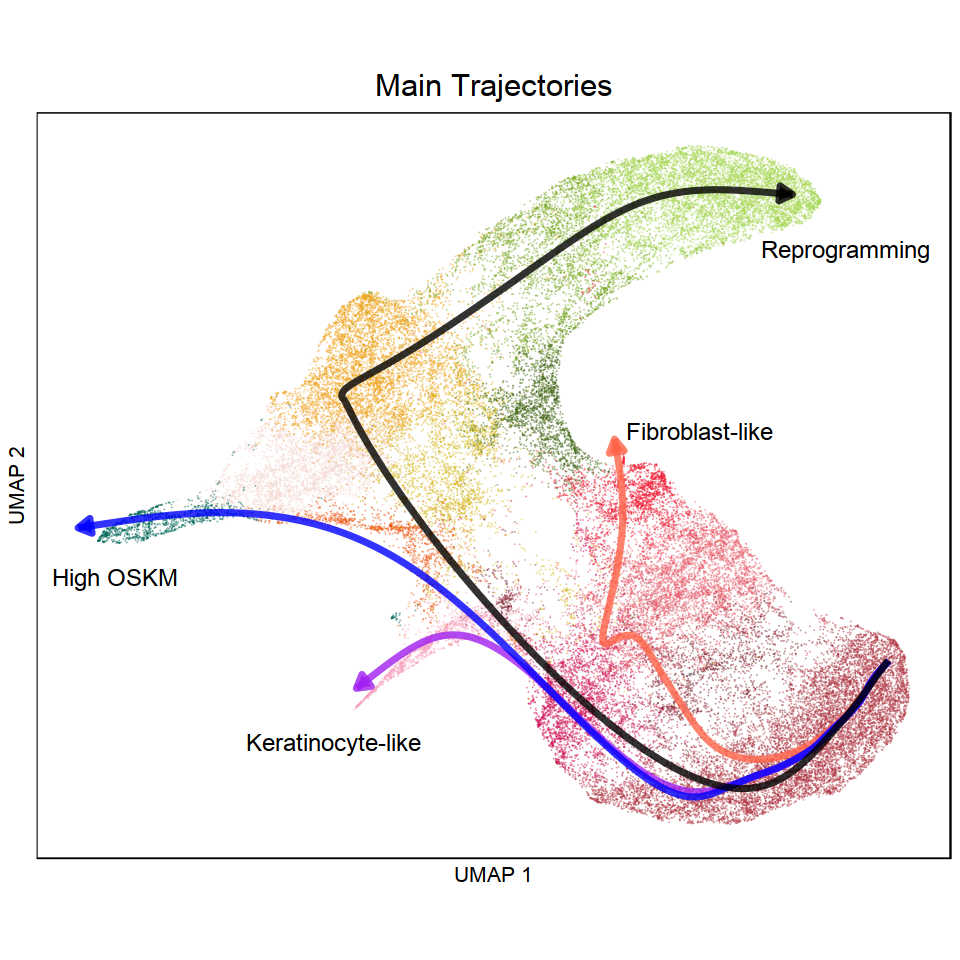

In [63]:
options(repr.plot.width = 8, repr.plot.height = 8)

path_plot

In [64]:
saveRDS(path_plot, file=sprintf("./subfigs/%s_traj_arrows.rds",
                                   format(Sys.Date(), "%Y%m%d")))

---

In [ ]:
sessionInfo()